In [ ]:
import pandas as pd
import numpy as np
from scipy import interpolate



In [ ]:
# Load data with proper datetime parsing
df = pd.read_csv('/content/bridge_dataset.csv.xls', parse_dates=['timestamp'])
df = df.set_index('timestamp').sort_index()

In [ ]:
df.columns.tolist()

['bridge_id',
 'sensor_id',
 'acceleration_x',
 'acceleration_y',
 'acceleration_z',
 'temperature_c',
 'humidity_percent',
 'wind_speed_mps',
 'fft_peak_freq',
 'fft_magnitude',
 'degradation_score',
 'structural_condition',
 'damage_class',
 'forecast_score_next_30d']

In [ ]:
df


,bridge_id,sensor_id,acceleration_x,acceleration_y,acceleration_z,temperature_c,humidity_percent,wind_speed_mps,fft_peak_freq,fft_magnitude,degradation_score,structural_condition,damage_class,forecast_score_next_30d
timestamp,,,,,,,,,,,,,,
2020-01-01 00:00:00,B001,S4,-0.428902,0.009163,-0.448430,24.263205,82.573476,9.129824,3.264360,1.393159,75.155898,3,Severe,83.164753
2020-01-01 00:15:00,B003,S3,0.086893,-0.005482,0.422973,19.343838,83.545112,6.676185,1.290251,0.190976,10.844521,0,No Damage,16.168653
2020-01-01 00:30:00,B003,S3,-0.168531,-0.703500,-0.403903,18.021082,41.881540,1.084121,4.899752,1.402845,61.673974,2,Moderate,65.254881
2020-01-01 00:45:00,B002,S3,-0.242926,-0.046838,-0.359685,19.908278,81.787200,0.003722,2.347590,0.659239,26.573856,1,Minor,29.030163
2020-01-01 01:00:00,B001,S2,0.175638,0.000792,-0.242574,30.995286,89.394147,1.032235,0.928626,0.733460,38.942145,1,Minor,34.534451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-14 21:45:00,B003,S4,0.431453,0.853124,-0.490435,23.603297,61.752247,11.051399,1.002591,0.443685,12.048458,0,No Damage,19.134199
2020-01-14 22:00:00,B002,S2,-0.373858,-0.336196,-0.329092,24.980988,36.506882,14.982856,2.170989,0.140034,75.641900,3,Severe,76.149429
2020-01-14 22:15:00,B003,S4,-0.126665,-0.352125,-0.378900,31.449722,70.221423,5.802638,1.922825,0.496188,0.000000,0,No Damage,7.676979


In [ ]:
def robust_resample(group):
    """Resampling with physical constraints and gap handling"""
    # Create 10-minute grid
    new_index = pd.date_range(group.index.min(), group.index.max(), freq='10T')

    # Initialize result dataframe
    result = pd.DataFrame(index=new_index)

    # Numeric columns with physical constraints
    num_cols = {
        'acceleration_x': (-2.0, 2.0),
        'acceleration_y': (-2.0, 2.0),
        'acceleration_z': (-2.0, 2.0),
        'temperature_c': (-10.0, 50.0),
        'humidity_percent': (0.0, 100.0),
        'wind_speed_mps': (0.0, 50.0),
        'fft_peak_freq': (0.0, None),
        'fft_magnitude': (0.0, None),
        'degradation_score': (0.0, 100.0),
        'forecast_score_next_30d': (0.0, 100.0)
    }

    # Interpolate numeric columns with bounds
    for col, (min_val, max_val) in num_cols.items():
        if group[col].notna().sum() > 1:  # Enough points to interpolate
            # Create interpolation function
            f = interpolate.interp1d(
                group.index.astype('int64'),  # Convert to nanoseconds
                group[col],
                kind='linear',
                bounds_error=False,
                fill_value='extrapolate'
            )
            # Apply interpolation
            result[col] = f(new_index.astype('int64'))
            # Apply physical constraints
            if min_val is not None:
                result[col] = result[col].clip(lower=min_val)
            if max_val is not None:
                result[col] = result[col].clip(upper=max_val)
        else:  # Not enough points - use nearest
            result[col] = group[col].reindex(new_index, method='nearest')

    # Categorical columns
    cat_cols = ['structural_condition', 'damage_class']
    for col in cat_cols:
        result[col] = group[col].reindex(new_index, method='ffill')

    return result

In [ ]:
# Process each bridge-sensor group
final_results = []
for (bridge, sensor), group in df.groupby(['bridge_id', 'sensor_id']):
    resampled = robust_resample(group)
    resampled['bridge_id'] = bridge
    resampled['sensor_id'] = sensor
    final_results.append(resampled)


/tmp/ipython-input-2879274266.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  new_index = pd.date_range(group.index.min(), group.index.max(), freq='10T')
/tmp/ipython-input-2879274266.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  new_index = pd.date_range(group.index.min(), group.index.max(), freq='10T')
/tmp/ipython-input-2879274266.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  new_index = pd.date_range(group.index.min(), group.index.max(), freq='10T')
/tmp/ipython-input-2879274266.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  new_index = pd.date_range(group.index.min(), group.index.max(), freq='10T')
/tmp/ipython-input-2879274266.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  new_in

In [ ]:
# Combine results
final_df = pd.concat(final_results).sort_index()

In [ ]:
# Verify
print("Missing values after processing:")
print(final_df.isna().sum())



Missing values after processing:
acceleration_x             0
acceleration_y             0
acceleration_z             0
temperature_c              0
humidity_percent           0
wind_speed_mps             0
fft_peak_freq              0
fft_magnitude              0
degradation_score          0
forecast_score_next_30d    0
structural_condition       0
damage_class               0
bridge_id                  0
sensor_id                  0
dtype: int64


In [ ]:
# Check physical constraints
print("\nTemperature range:", final_df['temperature_c'].min(), "to", final_df['temperature_c'].max())
print("Acceleration range:", final_df['acceleration_x'].min(), "to", final_df['acceleration_x'].max())




Temperature range: 7.310734969571929 to 41.53193723922199
Acceleration range: -0.8565628089972166 to 0.9582771043844847


In [ ]:
# Sample output
sample = final_df[
    (final_df['bridge_id'] == 'B001') &
    (final_df['sensor_id'] == 'S4')
].head(10)
print("\nSample output with realistic values:")
print(sample[['acceleration_x', 'temperature_c', 'damage_class']])


Sample output with realistic values:
                     acceleration_x  temperature_c damage_class
2020-01-01 00:00:00       -0.428902      24.263205       Severe
2020-01-01 00:10:00       -0.410346      23.612017       Severe
2020-01-01 00:20:00       -0.391790      22.960829       Severe
2020-01-01 00:30:00       -0.373233      22.309642       Severe
2020-01-01 00:40:00       -0.354677      21.658454       Severe
2020-01-01 00:50:00       -0.336121      21.007267       Severe
2020-01-01 01:00:00       -0.317565      20.356079       Severe
2020-01-01 01:10:00       -0.299009      19.704891       Severe
2020-01-01 01:20:00       -0.280453      19.053704       Severe
2020-01-01 01:30:00       -0.261896      18.402516       Severe


In [ ]:
final_df.reset_index().to_csv('Synchronized & Preprocessed.csv', index=False)
print("\nData successfully saved with realistic interpolation!")


Data successfully saved with realistic interpolation!


In [ ]:
from scipy.stats import skew, kurtosis
from scipy.fft import fft

In [ ]:
df = pd.read_csv("Synchronized & Preprocessed.csv", parse_dates=["index"])
df = df.set_index("index").sort_index()

print("✅ Data loaded")
print(df.head())

✅ Data loaded
                     acceleration_x  acceleration_y  acceleration_z  \
index                                                                 
2020-01-01 00:00:00       -0.428902        0.009163       -0.448430   
2020-01-01 00:10:00       -0.410346        0.010257       -0.432857   
2020-01-01 00:15:00        0.086893       -0.005482        0.422973   
2020-01-01 00:20:00       -0.391790        0.011350       -0.417284   
2020-01-01 00:25:00       -0.083390       -0.470827       -0.128278   

                     temperature_c  humidity_percent  wind_speed_mps  \
index                                                                  
2020-01-01 00:00:00      24.263205         82.573476        9.129824   
2020-01-01 00:10:00      23.612017         82.045667        9.239000   
2020-01-01 00:15:00      19.343838         83.545112        6.676185   
2020-01-01 00:20:00      22.960829         81.517858        9.348177   
2020-01-01 00:25:00      18.462001         55.769397    

In [ ]:
def extract_features(group):
    features = {}

    # --- Vibration Features ---
    for axis in ['acceleration_x', 'acceleration_y', 'acceleration_z']:
        series = group[axis].dropna()
        if len(series) > 0:
            features[f'{axis}_rms'] = np.sqrt(np.mean(series**2))
            features[f'{axis}_peak'] = series.abs().max()
            features[f'{axis}_mean'] = series.mean()
            features[f'{axis}_std'] = series.std()
            features[f'{axis}_skew'] = skew(series)
            features[f'{axis}_kurt'] = kurtosis(series)

            # Frequency-domain (FFT entropy on each axis)
            fft_vals = np.abs(fft(series.values))
            fft_norm = fft_vals / (fft_vals.sum() + 1e-8)
            features[f'{axis}_fft_entropy'] = -np.sum(fft_norm * np.log(fft_norm + 1e-8))

    # --- Temperature Features ---
    if "temperature_c" in group:
        features["temp_mean"] = group["temperature_c"].mean()
        features["temp_std"] = group["temperature_c"].std()
        features["temp_min"] = group["temperature_c"].min()
        features["temp_max"] = group["temperature_c"].max()

    # --- Wind Features ---
    if "wind_speed_mps" in group:
        features["wind_mean"] = group["wind_speed_mps"].mean()
        features["wind_std"] = group["wind_speed_mps"].std()
        features["wind_max"] = group["wind_speed_mps"].max()

    # --- Humidity Features (if available) ---
    if "humidity_percent" in group:
        features["humidity_mean"] = group["humidity_percent"].mean()
        features["humidity_std"] = group["humidity_percent"].std()

    # --- FFT Features (if available) ---
    if "fft_peak_freq" in group:
        features["fft_peak_freq_mean"] = group["fft_peak_freq"].mean()
        features["fft_peak_freq_std"] = group["fft_peak_freq"].std()

    if "fft_magnitude" in group:
        features["fft_mag_mean"] = group["fft_magnitude"].mean()
        features["fft_mag_std"] = group["fft_magnitude"].std()

    # --- Degradation Score / Forecast (if available) ---
    if "degradation_score" in group:
        features["deg_score_mean"] = group["degradation_score"].mean()
    if "forecast_score_next_30d" in group:
        features["forecast_score_mean"] = group["forecast_score_next_30d"].mean()

    # --- Target Variable ---
    if "damage_class" in group:
        features["damage_class"] = group["damage_class"].ffill().bfill().iloc[-1]
    if "structural_condition" in group:
        features["structural_condition"] = group["structural_condition"].ffill().bfill().iloc[-1]

    return pd.Series(features)


In [ ]:
# Apply feature extraction for each bridge-sensor group
feature_df = df.groupby(["bridge_id", "sensor_id"]).apply(extract_features).reset_index()

print("Feature extraction completed")
print("Shape:", feature_df.shape)
print(feature_df.head())


Feature extraction completed
Shape: (12, 40)
  bridge_id sensor_id  acceleration_x_rms  acceleration_x_peak  \
0      B001        S1            0.228907             0.736769   
1      B001        S2            0.264107             0.945133   
2      B001        S3            0.228555             0.958277   
3      B001        S4            0.223008             0.761301   
4      B002        S1            0.298982             0.951311   

   acceleration_x_mean  acceleration_x_std  acceleration_x_skew  \
0            -0.000807            0.228964            -0.104969   
1             0.017314            0.263605             0.024261   
2            -0.010211            0.228386             0.119564   
3            -0.003444            0.223038             0.113792   
4             0.051806            0.294533            -0.090536   

   acceleration_x_kurt  acceleration_x_fft_entropy  acceleration_y_rms  ...  \
0            -0.362348                    6.208513            0.261084  ... 

/tmp/ipython-input-4202108116.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_df = df.groupby(["bridge_id", "sensor_id"]).apply(extract_features).reset_index()


In [ ]:
# Save extracted features
feature_df.to_csv("feature engineering.csv", index=False)

print("✅ Saved extracted features to bridge_features.csv")


✅ Saved extracted features to bridge_features.csv


In [ ]:
import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(tf.__version__)

2.19.0


In [ ]:
# Path to your synchronized, preprocessed time-series (10-min grid)
DATA_PATH = "Synchronized & Preprocessed.csv"  # change if needed

df = pd.read_csv(DATA_PATH, parse_dates=["index"])
df = df.set_index("index").sort_index()

# Basic sanity checks
required_cols = ["bridge_id","sensor_id","acceleration_x","acceleration_y","acceleration_z",
                 "temperature_c","wind_speed_mps","humidity_percent","damage_class"]
missing = [c for c in required_cols if c not in df.columns]
assert not missing, f"Missing columns: {missing}"

print(df.shape, df.index.min(), df.index.max())
df.head()


(23735, 14) 2020-01-01 00:00:00 2020-01-14 22:45:00


,acceleration_x,acceleration_y,acceleration_z,temperature_c,humidity_percent,wind_speed_mps,fft_peak_freq,fft_magnitude,degradation_score,forecast_score_next_30d,structural_condition,damage_class,bridge_id,sensor_id
index,,,,,,,,,,,,,,
2020-01-01 00:00:00,-0.428902,0.009163,-0.448430,24.263205,82.573476,9.129824,3.264360,1.393159,75.155898,83.164753,3,Severe,B001,S4
2020-01-01 00:10:00,-0.410346,0.010257,-0.432857,23.612017,82.045667,9.239000,3.343777,1.342711,72.510558,79.995385,3,Severe,B001,S4
2020-01-01 00:15:00,0.086893,-0.005482,0.422973,19.343838,83.545112,6.676185,1.290251,0.190976,10.844521,16.168653,0,No Damage,B003,S3
2020-01-01 00:20:00,-0.391790,0.011350,-0.417284,22.960829,81.517858,9.348177,3.423194,1.292263,69.865218,76.826016,3,Severe,B001,S4
2020-01-01 00:25:00,-0.083390,-0.470827,-0.128278,18.462001,55.769397,2.948142,3.696585,0.998889,44.730823,48.892805,0,No Damage,B003,S3


In [ ]:
WINDOW_STEPS = 12     # 12 x 10min = 2 hours per sample
STEP = 1              # slide by 1 time-step
MIN_SEQ = WINDOW_STEPS

vib_cols = ["acceleration_x","acceleration_y","acceleration_z"]
env_cols = [
    "temperature_c","wind_speed_mps","humidity_percent",
]
# Add optional engineered columns if present
for c in ["fft_peak_freq","fft_magnitude","degradation_score","forecast_score_next_30d"]:
    if c in df.columns:
        env_cols.append(c)

cat_label = "damage_class"

def build_sequences(g):
    g = g.sort_index()
    X_vib, X_env, y = [], [], []
    n = len(g)
    if n < MIN_SEQ:
        return None

    # Ensure no NaNs (should be handled already, but just in case)
    g[vib_cols + env_cols] = g[vib_cols + env_cols].interpolate(limit_direction="both")

    labels = g[cat_label].astype(str).ffill().bfill().values
    vib = g[vib_cols].values
    env = g[env_cols].values

    for start in range(0, n - WINDOW_STEPS + 1, STEP):
        end = start + WINDOW_STEPS
        X_vib.append(vib[start:end])   # shape: (T, 3)
        X_env.append(env[start:end])   # shape: (T, E)
        # Use the label at the end of the window (or majority vote)
        y.append(labels[end - 1])

    return np.array(X_vib), np.array(X_env), np.array(y)

# Build dataset across all bridge/sensor streams
Xs_vib, Xs_env, Ys = [], [], []
for (b, s), g in df.groupby(["bridge_id","sensor_id"]):
    out = build_sequences(g)
    if out is None:
        continue
    xv, xe, yy = out
    Xs_vib.append(xv)
    Xs_env.append(xe)
    Ys.append(yy)

X_vib = np.concatenate(Xs_vib, axis=0)
X_env = np.concatenate(Xs_env, axis=0)
y_raw = np.concatenate(Ys, axis=0)

print("X_vib:", X_vib.shape, "X_env:", X_env.shape, "y:", y_raw.shape)
print("Classes:", pd.Series(y_raw).value_counts())


X_vib: (23603, 12, 3) X_env: (23603, 12, 7) y: (23603,)
Classes: Minor        8996
Moderate     6540
No Damage    6392
Severe       1675
Name: count, dtype: int64


In [ ]:
le = LabelEncoder()
y_int = le.fit_transform(y_raw)
num_classes = len(le.classes_)
print("Class map:", dict(zip(le.classes_, range(num_classes))))

# Single stratified split (you can use k-fold below if you want)
Xv_train, Xv_val, Xe_train, Xe_val, y_train, y_val = train_test_split(
    X_vib, X_env, y_int, test_size=0.2, random_state=SEED, stratify=y_int
)

print("Train:", Xv_train.shape, Xe_train.shape, y_train.shape)
print("Val:  ", Xv_val.shape,   Xe_val.shape,   y_val.shape)


Class map: {np.str_('Minor'): 0, np.str_('Moderate'): 1, np.str_('No Damage'): 2, np.str_('Severe'): 3}
Train: (18882, 12, 3) (18882, 12, 7) (18882,)
Val:   (4721, 12, 3) (4721, 12, 7) (4721,)


**Building blocks: Transformer encoder (light), CNN+LSTM**

In [ ]:
def transformer_block(x, num_heads=4, key_dim=32, ff_mult=2, dropout=0.1, name="tr"):
    # LayerNorm → MHA → Dropout → Residual
    attn_out = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, name=f"{name}_mha")(x, x)
    attn_out = layers.Dropout(dropout, name=f"{name}_attn_do")(attn_out)
    x1 = layers.LayerNormalization(epsilon=1e-6, name=f"{name}_ln1")(x + attn_out)
    # Feed-forward
    ff = layers.Dense(ff_mult*key_dim, activation="gelu", name=f"{name}_ff1")(x1)
    ff = layers.Dense(x.shape[-1], activation=None, name=f"{name}_ff2")(ff)
    ff = layers.Dropout(dropout, name=f"{name}_ff_do")(ff)
    x2 = layers.LayerNormalization(epsilon=1e-6, name=f"{name}_ln2")(x1 + ff)
    return x2

def build_model(window_steps, vib_dim=3, env_dim=None, num_classes=4):
    # Vibration branch: 1D-CNN → BiLSTM → Transformer
    vib_in = Input(shape=(window_steps, vib_dim), name="vib_in")
    v = layers.Conv1D(64, 5, padding="same", activation="relu")(vib_in)
    v = layers.BatchNormalization()(v)
    v = layers.Conv1D(128, 3, padding="same", activation="relu")(v)
    v = layers.MaxPooling1D(2)(v)
    v = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(v)
    v = transformer_block(v, num_heads=4, key_dim=32, ff_mult=2, dropout=0.1, name="vib_tr")
    v = layers.GlobalAveragePooling1D()(v)
    v = layers.Dropout(0.2)(v)

    # Environmental branch: compact LSTM (can also be CNN1D if you prefer)
    env_in = Input(shape=(window_steps, env_dim), name="env_in")
    e = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(env_in)
    e = layers.GlobalAveragePooling1D()(e)
    e = layers.Dropout(0.2)(e)

    # Fuse
    z = layers.Concatenate()([v, e])
    z = layers.Dense(128, activation="relu")(z)
    z = layers.Dropout(0.3)(z)
    z = layers.Dense(64, activation="relu")(z)
    out = layers.Dense(num_classes, activation="softmax", name="cls_out")(z)

    model = Model(inputs=[vib_in, env_in], outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_model(
    window_steps=WINDOW_STEPS,
    vib_dim=X_vib.shape[-1],
    env_dim=X_env.shape[-1],
    num_classes=num_classes
)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ vib_in (InputLayer) │ (None, 12, 3)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 12, 64)    │      1,024 │ vib_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 64)    │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 12, 128)   │     24,704 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 6, 128)    │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 6, 128)    │     98,816 │ max_pooling1d_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vib_tr_mha          │ (None, 6, 128)    │     66,048 │ bidirectional_2[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vib_tr_attn_do      │ (None, 6, 128)    │          0 │ vib_tr_mha[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 6, 128)    │          0 │ bidirectional_2[… │
│                     │                   │            │ vib_tr_attn_do[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vib_tr_ln1          │ (None, 6, 128)    │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vib_tr_ff1 (Dense)  │ (None, 6, 64)     │      8,256 │ vib_tr_ln1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vib_tr_ff2 (Dense)  │ (None, 6, 128)    │      8,320 │ vib_tr_ff1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vib_tr_ff_do        │ (None, 6, 128)    │          0 │ vib_tr_ff2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 6, 128)    │          0 │ vib_tr_ln1[0][0], │
│                     │                   │            │ vib_tr_ff_do[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ env_in (InputLayer) │ (None, 12, 7)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vib_tr_ln2          │ (None, 6, 128)    │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 12, 64)    │     10,240 │ env_in[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ vib_tr_ln2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ bidirectional_3[

 Total params: 251,396 (982.02 KB)

 Trainable params: 251,268 (981.52 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
ckpt_path = "best_hybrid_model.keras"
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1)
]

history = model.fit(
    x={"vib_in": Xv_train, "env_in": Xe_train},
    y=y_train,
    validation_data=({"vib_in": Xv_val, "env_in": Xe_val}, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/100
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4880 - loss: 1.1212
Epoch 1: val_accuracy improved from -inf to 0.59754, saving model to best_hybrid_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 31s 75ms/step - accuracy: 0.4885 - loss: 1.1205 - val_accuracy: 0.5975 - val_loss: 0.9204 - learning_rate: 0.0010
Epoch 2/100
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5921 - loss: 0.9451
Epoch 2: val_accuracy improved from 0.59754 to 0.63186, saving model to best_hybrid_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.5922 - loss: 0.9449 - val_accuracy: 0.6319 - val_loss: 0.8707 - learning_rate: 0.0010
Epoch 3/100
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6166 - loss: 0.9066
Epoch 3: val_accuracy improved from 0.63186 to 0.64202, saving model to best_hybrid_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - accuracy: 0.6166 - loss: 0.9064 - val_accuracy: 0.6420 - val_loss: 0.8422 - learning_rate: 0.0010
Epoch 4/100
295/296 ━━

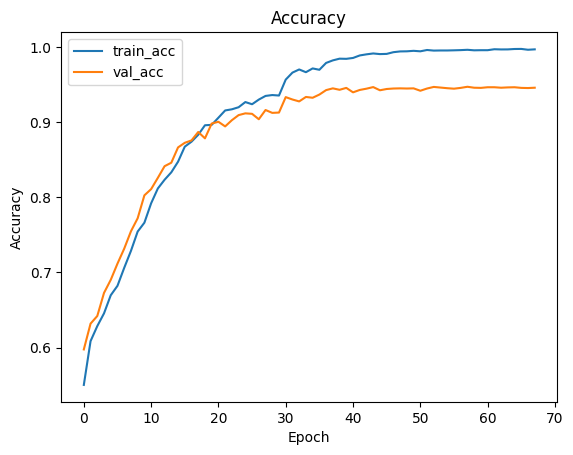

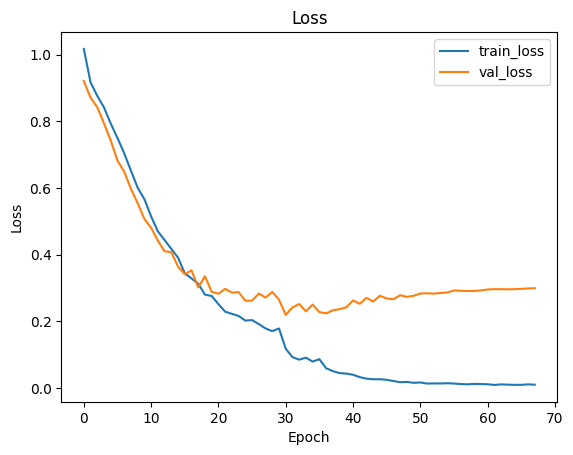

In [ ]:
# Plot training curves
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")
plt.show()


              precision    recall  f1-score   support

       Minor       0.95      0.96      0.95      1799
    Moderate       0.94      0.94      0.94      1308
   No Damage       0.95      0.94      0.95      1279
      Severe       0.93      0.93      0.93       335

    accuracy                           0.95      4721
   macro avg       0.94      0.94      0.94      4721
weighted avg       0.95      0.95      0.95      4721



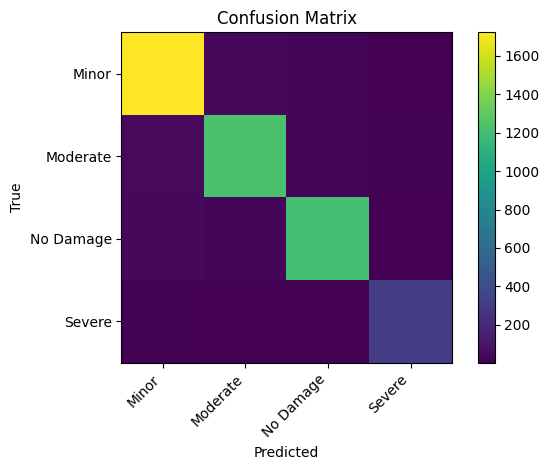

In [ ]:
# Predictions
y_pred_probs = model.predict({"vib_in": Xv_val, "env_in": Xe_val}, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_val, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm,   interpolation="nearest")
ax.set_title("Confusion Matrix")
plt.colorbar(im)
ax.set_xticks(range(num_classes)); ax.set_yticks(range(num_classes))
ax.set_xticklabels(le.classes_, rotation=45, ha="right"); ax.set_yticklabels(le.classes_)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


In [ ]:
FOLDS = 3
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_acc = []

for i, (tr_idx, va_idx) in enumerate(skf.split(X_vib, y_int), 1):
    print(f"\n===== Fold {i}/{FOLDS} =====")
    Xv_tr, Xv_va = X_vib[tr_idx], X_vib[va_idx]
    Xe_tr, Xe_va = X_env[tr_idx], X_env[va_idx]
    y_tr, y_va = y_int[tr_idx], y_int[va_idx]

    m = build_model(WINDOW_STEPS, X_vib.shape[-1], X_env.shape[-1], num_classes)
    cb = [
        EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6)
    ]
    h = m.fit(
        {"vib_in": Xv_tr, "env_in": Xe_tr}, y_tr,
        validation_data=({"vib_in": Xv_va, "env_in": Xe_va}, y_va),
        epochs=60, batch_size=64, callbacks=cb, verbose=0
    )
    va_acc = max(h.history["val_accuracy"])
    fold_acc.append(va_acc)
    print(f"Fold {i} best val_acc: {va_acc:.4f}")

print("\nCV Accuracies:", [round(a,4) for a in fold_acc])
print("CV Mean Acc:", np.mean(fold_acc), "±", np.std(fold_acc))




===== Fold 1/3 =====
Fold 1 best val_acc: 0.9363

===== Fold 2/3 =====
Fold 2 best val_acc: 0.9390

===== Fold 3/3 =====
Fold 3 best val_acc: 0.9364

CV Accuracies: [0.9363, 0.939, 0.9364]
CV Mean Acc: 0.9372537136077881 ± 0.001231099492862231


In [ ]:
model.save("hybrid_shm_model.keras")
# Save label classes
pd.Series(le.classes_).to_csv("label_classes.csv", index=False, header=["class"])
print("Saved: hybrid_shm_model.keras and label_classes.csv")


Saved: hybrid_shm_model.keras and label_classes.csv


In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf


In [ ]:
import pandas as pd

# Save label classes after encoding
pd.Series(le.classes_).to_csv("label_classes.csv", index=False, header=["class"])
